In [106]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [107]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

scene_model = models.resnet18(num_classes=365)
scene_model.fc = nn.Linear(scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
scene_model.load_state_dict(scene_state_dict)
scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [108]:
from deepproblog.network import Network 
import torch.nn.functional as F

# Wrap HF model so forward() returns logits and handles list input
class HFWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model

    def forward(self, x):
        # Handle the case where DeepProbLog passes a list of tensors
        face_probs_list = []
        face_confidences = []

        for face_tensor in x:
            face_batch = face_tensor.unsqueeze(0)
            outputs = self.hf_model(face_batch)
            probs = F.softmax(outputs.logits, dim=-1)

            face_probs_list.append(probs.squeeze(0))  # Remove batch dimension
            face_confidences.append(torch.max(probs).item())  # Max confidence for this face

        # Compute a weighted average
        if len(face_probs_list) > 1:
            weights = torch.tensor(face_confidences, device=face_probs_list[0].device)
            weights = weights / weights.sum()  # Normalize weights

            # Stack all the face probabilities
            all_face_probs = torch.stack(face_probs_list, dim=0) # Shape: [num_faces, 7]

            # Now weighted average
            weighted_avg = torch.sum(weights.unsqueeze(1) * all_face_probs, dim=0)
            return weighted_avg.unsqueeze(0)
        
        else:
            return face_probs_list[0].unsqueeze(0)
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Handle the case where DeepProbLog passes a list of tensors
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            # Add batch dimension if missing
            x = x.unsqueeze(0)
            
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs

scene_model = SceneWrapper(scene_model)
emotion_model = HFWrapper(emotion_model)

In [109]:
# Create a dataframe for the FindingEmo dataset
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [110]:
df_findingEmo.head()

,image_path,valence,arousal,emotion
0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,2,Trust
1,Run_2/Frustrated forty-something office/team-w...,0,2,Interest
2,Run_1/Violent youth festival/1042373588.jpg,2,2,Interest
3,Run_2/Remorseful toddlers court of law/dcfs-co...,1,2,Interest
4,Run_2/Shame elderly sports/3364887-46.jpg,0,3,Apprehension


In [111]:
df_findingEmo.head()

,image_path,valence,arousal,emotion
0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,2,Trust
1,Run_2/Frustrated forty-something office/team-w...,0,2,Interest
2,Run_1/Violent youth festival/1042373588.jpg,2,2,Interest
3,Run_2/Remorseful toddlers court of law/dcfs-co...,1,2,Interest
4,Run_2/Shame elderly sports/3364887-46.jpg,0,3,Apprehension


In [112]:
print(len(df_findingEmo))

21372


In [113]:
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")

In [114]:
# # The dataset contains images that cannot be loaded, we will filter them out
# # More efficient approach - check validity and filter
# print(f"Starting with {len(df_findingEmo)} images")

# def is_image_valid(image_path, base_dir):
#     """Check if image exists and can be loaded"""
#     img_path = os.path.join(base_dir, image_path)
#     # get the index of the row where image_path is located
#     row_index = df_findingEmo[df_findingEmo['image_path'] == image_path].index[0]
#     # print every 100th index
#     if row_index % 100 == 0:
#         print(f"Checking image {row_index}/{len(df_findingEmo)}: {img_path}")
    
#     if not os.path.exists(img_path):
#         return False
    
#     try:
#         img = cv2.imread(img_path)
#         return img is not None
#     except:
#         return False

# # Apply validation to all rows at once
# base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
# valid_mask = df_findingEmo['image_path'].apply(lambda x: is_image_valid(x, base_findingemo_dir))

# # Filter dataframe to keep only valid images
# df_findingEmo_cleaned = df_findingEmo[valid_mask].reset_index(drop=True)

# print(f"Filtered to {len(df_findingEmo_cleaned)} valid images")
# print(f"Removed {len(df_findingEmo) - len(df_findingEmo_cleaned)} invalid images")

# # Update the main dataframe
# df_findingEmo = df_findingEmo_cleaned

# # Write to a new CSV to avoid redoing this
# df_findingEmo.to_csv(os.path.join(labels_dir, "annotations_cleaned.csv"), index=False)

In [115]:
# train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [116]:
len(train_df), len(test_df)

(17097, 4275)

In [117]:
test_df.head()

,image_path,valence,arousal,emotion
0,Run_2/Tearful seniors ceremony/north-korean-fe...,-2,5,Grief
1,Run_2/Optimistic people festival/film-festival...,2,3,Serenity
2,Run_2/Appreciative elderly office/5863790318_8...,0,1,Boredom
3,Run_2/Appalled children soccer/paul-gascoigne-...,0,4,Apprehension
4,Run_2/Guilt adolescents theater/Crucible_10-12...,-2,4,Apprehension


In [118]:
from mtcnn import MTCNN
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    def __init__(self, subset):
        self.subset = subset
        self.face_detector = MTCNN()

        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
# Will return a list of tensors corresponding to all the detected faces.
# If no face is detected, just return the tensor of the image.
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect the faces
        face_results = self.face_detector.detect_faces(img)

        face_tensors = []

        if len(face_results) > 0:
            for face_result in face_results:
                x, y, w, h = face_result['box']

                # Handle negative coordinates and bounds
                x = max(0, x)
                y = max(0, y)
                x2 = min(img.shape[1], x + w)
                y2 = min(img.shape[0], y + h)

                # Face crop
                face_crop = img[y:y2, x:x2] 
                # Skip if the crop is too small
                if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                # Converting to PIL and process it with HF processor
                face_pil = Image.fromarray(face_crop)
                face_input = emotion_processor(images=face_pil, return_tensors="pt")
                face_tensors.append(face_input['pixel_values'].squeeze(0))

        if len(face_tensors) == 0:
            # Use whole image as fallback
            img_pil = Image.fromarray(img)
            face_input = emotion_processor(images = img_pil, return_tensors="pt")
            face_tensors.append(face_input['pixel_values'].squeeze(0))
            
        return face_tensors

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [120]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

mapping = {
    'Acceptance': 'neutral',
    'Admiration': 'happy',
    'Amazement': 'surprise',
    'Anger': 'angry',
    'Annoyance': 'angry',
    'Anticipation': 'neutral',  
    'Apprehension': 'fear',
    'Boredom': 'neutral',
    'Disgust': 'disgust',
    'Distraction': 'neutral',
    'Ecstasy': 'happy',
    'Fear': 'fear',
    'Grief': 'sad',
    'Interest': 'neutral',
    'Joy': 'happy',
    'Loathing': 'disgust',
    'Pensiveness': 'sad',
    'Rage': 'angry',
    'Sadness': 'sad',
    'Serenity': 'happy',
    'Surprise': 'surprise',
    'Terror': 'fear',
    'Trust': 'happy',    
    'Vigilance': 'neutral' 
}

model_emotion_to_index = {emotion: idx for idx, emotion in enumerate(emotion_categories)}

def map_findingemo_emotion_to_index(findingemo_emotion):
    # Map FindingEmo emotion string to emotion model index, neutral is default when not found
    model_emotion = mapping.get(findingemo_emotion, 'neutral')
    return model_emotion_to_index[model_emotion]

Number of face tensors: 3
Each face tensor shape: torch.Size([3, 224, 224])
Number of face tensors: 3
Ground truth emotion:  fear


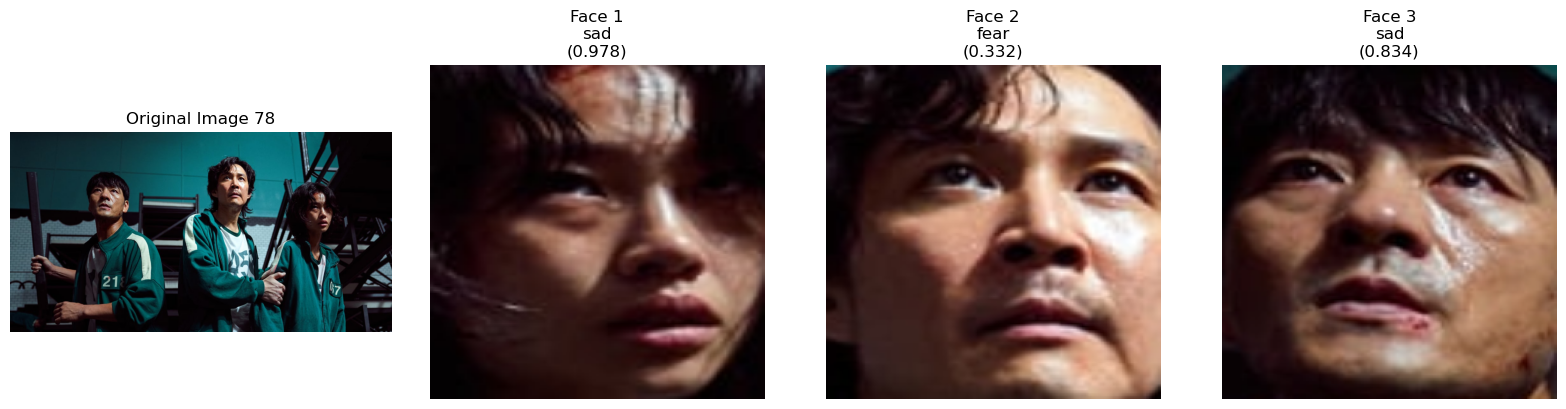


Top 3 emotions (weighted average):
  1. sad: 0.8207
  2. surprise: 0.1044
  3. fear: 0.0545

Top 5 emotions for each face:

Face 1:
  1. sad: 0.9778
  2. surprise: 0.0128
  3. fear: 0.0035
  4. angry: 0.0027
  5. disgust: 0.0014

Face 2:
  1. fear: 0.3325
  2. sad: 0.3259
  3. surprise: 0.2594
  4. angry: 0.0772
  5. happy: 0.0020

Face 3:
  1. sad: 0.8338
  2. surprise: 0.1502
  3. angry: 0.0078
  4. fear: 0.0035
  5. happy: 0.0024


In [ ]:
# Testing the HFWrapper with multiple faces
test_idx = random.randint(0, 100)
face_tensors = FindingEmoFace_train[(test_idx,)]
print(f"Number of face tensors: {len(face_tensors)}")
print(f"Each face tensor shape: {face_tensors[0].shape}")
# Display the original image for reference and the detected faces
image_path = train_df.iloc[test_idx]['image_path']
img_path = os.path.join(base_findingemo_dir, image_path)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Number of face tensors: {len(face_tensors)}")
femo = train_df.iloc[test_idx]['emotion']
print("Ground truth emotion: ", mapping[femo])

# Get emotion predictions from the model
with torch.no_grad():
    emotion_probs = emotion_model(face_tensors)

# Get individual face predictions for display
individual_face_predictions = []
individual_face_full_probs = []
for i, face_tensor in enumerate(face_tensors):
    with torch.no_grad():
        face_batch = face_tensor.unsqueeze(0)
        outputs = emotion_model.hf_model(face_batch)
        face_probs = F.softmax(outputs.logits, dim=-1)
        top_emotion_idx = torch.argmax(face_probs, dim=1).item()
        confidence = torch.max(face_probs).item()
        individual_face_predictions.append((top_emotion_idx, confidence))
        individual_face_full_probs.append(face_probs.squeeze(0)) 

# Create subplot layout: original + all faces
num_faces = len(face_tensors)
plt.figure(figsize=(4 * (num_faces + 1), 4))

# Display original image
plt.subplot(1, num_faces + 1, 1)
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Original Image {test_idx}")

# Display each face tensor with individual predictions
for i, face_tensor in enumerate(face_tensors):
    # Convert tensor to displayable image
    face_img = face_tensor.permute(1, 2, 0).numpy()
    face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())
    
    # Get individual prediction for this face
    emotion_idx, confidence = individual_face_predictions[i]
    emotion_name = emotion_categories[emotion_idx]
    
    plt.subplot(1, num_faces + 1, i + 2)
    plt.imshow(face_img)
    plt.axis('off')
    plt.title(f'Face {i + 1}\n{emotion_name}\n({confidence:.3f})')

plt.tight_layout()
plt.show()

# Display final weighted average predictions
print(f"\nTop 3 emotions (weighted average):")
top_emotions = torch.topk(emotion_probs, k=3).indices.squeeze().tolist()
for i, idx in enumerate(top_emotions):
    print(f"  {i+1}. {emotion_categories[idx]}: {emotion_probs[0, idx].item():.4f}")

# Show top 5 emotions for each individual face
print(f"\nTop 5 emotions for each face:")
for i, face_probs in enumerate(individual_face_full_probs):
    print(f"\nFace {i+1}:")
    top_5_emotions = torch.topk(face_probs, k=5)
    for j, (score, idx) in enumerate(zip(top_5_emotions.values, top_5_emotions.indices)):
        print(f"  {j+1}. {emotion_categories[idx.item()]}: {score.item():.4f}")

In [139]:
print(emotion_probs)

tensor([[1.6210e-02, 1.4423e-03, 5.4538e-02, 1.8140e-03, 8.2074e-01, 1.0444e-01,
         8.0708e-04]])


In [60]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

# def map_findingemo_scene_to_index(findingemo_scene):
#     # Map FindingEmo scene string to scene model index, 'living_room' is default when not found
#     model_scene = mapping.get(findingemo_scene, 'living_room')
#     return model_scene_to_index[model_scene]

In [61]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant
from deepproblog.query import Query
from deepproblog.train import train_model

In [62]:
# First, create the network objects (you need to add this part)
simple_face_network = Network(emotion_model, "face_net", batching=True)
simple_scene_network = Network(scene_model, "scene_net", batching=True)

num_emotions = len(emotion_categories)
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

# Create integrated Prolog file with dynamic indices
prolog = f"""
nn(face_net,[X],Y,{emotion_indices}) :: face_emotion(X,Y).
nn(scene_net,[X],Y,{scene_indices}) :: scene_category(X,Y).

% Query both face emotion and scene category for the same image
emotion_and_scene(FaceImg, SceneImg, EmotionIdx, SceneIdx) :-
    face_emotion(FaceImg, EmotionIdx),
    scene_category(SceneImg, SceneIdx).

% Individual queries
emotion(FaceImg, EmotionIdx) :-
    face_emotion(FaceImg, EmotionIdx).

scene(SceneImg, SceneIdx) :-
    scene_category(SceneImg, SceneIdx).
"""

# Write the integrated Prolog file
with open(os.path.join(script_dir, "integrated.pl"), "w") as f:
    f.write(prolog)

In [63]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [64]:
# Create integrated model
integrated_model = Model(os.path.join(script_dir, "integrated.pl"), [simple_face_network, simple_scene_network])
integrated_model.set_engine(ExactEngine(integrated_model), cache=True)

# Register tensor sources
integrated_model.add_tensor_source("train_face", FindingEmoFace_train)
integrated_model.add_tensor_source("test_face", FindingEmoFace_test)
integrated_model.add_tensor_source("train_scene", FindingEmoScene_train)
integrated_model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


In [65]:
class SocialCognition(Dataset, TorchDataset):
    def __init__(self, indices, subset="train"):
        self.indices = indices
        self.subset = subset
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        real_idx = self.indices[index]
        if self.subset == "train":
            face_tensor = FindingEmoFace_train[(real_idx,)]
            scene_tensor = FindingEmoScene_train[(real_idx,)]
            emotion_idx = map_findingemo_emotion_to_index(str(train_df.iloc[real_idx]["emotion"]))
        else:
            face_tensor = FindingEmoFace_test[(real_idx,)]
            scene_tensor = FindingEmoScene_test[(real_idx,)]
            emotion_idx = map_findingemo_emotion_to_index(str(test_df.iloc[real_idx]["emotion"]))
        
        return (face_tensor, scene_tensor), emotion_idx
    
    def to_query(self, i):
       pass
    
    def _get_predicted_scene(self, real_idx):
        # Get the most likely scene for this image using the scene network
        if self.subset == "train":
            scene_tensor = FindingEmoScene_train[(real_idx,)]
        else:
            scene_tensor = FindingEmoScene_test[(real_idx,)]
        
        with torch.no_grad():
            scene_tensor = scene_tensor.unsqueeze(0)
            scene_probs = scene_model(scene_tensor)
            predicted_scene_idx = torch.argmax(scene_probs, dim=1).item()
        
        return predicted_scene_idx

In [66]:
# # Test sample
# test_sample_idx = train_indices[3]

# # Display the image for reference
# image_path = train_df.iloc[test_sample_idx]['image_path']
# img_path = os.path.join(base_findingemo_dir, image_path)
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.axis('off')
# plt.title(f"Test Image {test_sample_idx}")
# plt.show()

# # Get ground truth emotion
# true_emotion = train_df.iloc[test_sample_idx]['emotion']
# true_emotion_idx = map_findingemo_emotion_to_index(str(true_emotion))
# # print(f"Ground truth emotion: {true_emotion} (index: {true_emotion_idx})")

# # Create dataset with predicted scenes
# predicted_dataset = SocialCognition(
#     [test_sample_idx], 
#     subset="train", 
# )

# # Get predicted scene
# predicted_scene_idx = predicted_dataset._get_predicted_scene(test_sample_idx)
# predicted_scene_name = scene_categories[predicted_scene_idx]
# print(f"Predicted scene: {predicted_scene_name} (index: {predicted_scene_idx})")

# # Test all query types with predicted scene
# emotion_query_pred = Query(
#     Term("emotion", Term("tensor", Term("train_face", Constant(test_sample_idx))), Constant(true_emotion_idx)),
#     substitution={}
# )

# scene_query_pred = Query(
#     Term("scene", Term("tensor", Term("train_scene", Constant(test_sample_idx))), Constant(predicted_scene_idx)),
#     substitution={}
# )

# combined_query_pred = Query(
#     Term("emotion_and_scene", 
#          Term("tensor", Term("train_face", Constant(test_sample_idx))),
#          Term("tensor", Term("train_scene", Constant(test_sample_idx))),
#          Constant(true_emotion_idx), 
#          Constant(predicted_scene_idx)),
#     substitution={}
# )


# results_pred = integrated_model.solve([emotion_query_pred, scene_query_pred, combined_query_pred])

# emotion_prob_pred = list(results_pred[0].result.values())[0]
# scene_prob_pred = list(results_pred[1].result.values())[0]
# combined_prob_pred = list(results_pred[2].result.values())[0]

# print(f"Emotion query: P({emotion_categories[true_emotion_idx]}) = {emotion_prob_pred:.4f}")
# print(f"Scene query: P({predicted_scene_name}) = {scene_prob_pred:.4f}")
# print(f"Combined query: P({emotion_categories[true_emotion_idx]} AND {predicted_scene_name}) = {combined_prob_pred:.4f}")

In [67]:
# combined_query_2 = Query(
#     Term("emotion_and_scene", 
#          Term("tensor", Term("train_face", Constant(test_sample_idx))),
#          Term("tensor", Term("train_scene", Constant(test_sample_idx))),
#          None, 
#          None),
#     substitution={}
# )

In [68]:
# results_pred = integrated_model.solve([combined_query_2])
# print(results_pred)

In [69]:
# # Extract the probability dictionary from the result
# prob_dict = results_pred[0].result

# # Convert to a more readable format
# results_list = []
# for key, prob in prob_dict.items():
#     # Parse the key to extract emotion and scene indices
#     key_str = str(key)
#     # Extract the last two numbers from the key
#     parts = key_str.split(',')
#     emotion_idx = int(parts[-2])
#     scene_idx = int(parts[-1].rstrip(')'))
    
#     results_list.append({
#         'emotion_idx': emotion_idx,
#         'scene_idx': scene_idx,
#         'emotion': emotion_categories[emotion_idx],
#         'scene': scene_categories[scene_idx],
#         'probability': float(prob)
#     })

# # Sort by probability (highest first)
# results_sorted = sorted(results_list, key=lambda x: x['probability'], reverse=True)

# # Show top 10 predictions
# print("Top 10 emotion-scene combinations:")
# for i, result in enumerate(results_sorted[:10]):
#     print(f"{i+1}. {result['emotion']} + {result['scene']}: {result['probability']:.6f}")

# # Show top predictions for each emotion
# print("\nTop scene for each emotion:")
# emotion_top = {}
# for result in results_sorted:
#     emotion = result['emotion']
#     if emotion not in emotion_top:
#         emotion_top[emotion] = result
#         print(f"{emotion}: {result['scene']} ({result['probability']:.6f})")